<a href="https://colab.research.google.com/github/AMP2233/intermediate-python-course/blob/master/Proyecto_de_Clasificaci%C3%B3n_de_im%C3%A1genes_con_Python_y_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Clasificador de Imagenes
__Estudiante:__ Adrian Livio Carhuaz Encinas \
__Materia:__ Sistemas Inteligentes \
__Fecha:__ 7 de Noviembre del 2023

## 1. Descripccion y muestras del set de datos

En este caso se selecciono un set de datos de numeros llamado `mnist` este set de datos se saco de `tensorflow_datasets`, aqui se descarga los datos para poderlos utilizar en le clasificador de imagenes. Ademas se muestra como se ha realizado el prepocesamiento de la imagen tomando 25 muestras y enbase a eso ver como las clasifica.

### 1.1 Descarga del set de datos

In [ ]:
# Se importan las librerias que se van a utilzar
import tensorflow as tf            #Libreria del tensorflow
import tensorflow_datasets as tfds #Libreria del datasheet del tensorflow

In [ ]:
#Descargar set de datos de MNIST
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

### 1.2 Contenido del dataset
Al imprimir el set de datos, al imprimir la variable `metadatos` muestra que trae el dataset, en este caso nos dice que consta de 10000 imagenes del `test` y 60000 del `train`. Las imagenes son 28 x 28 pixeles y cuenta con un total de 10 clases

In [ ]:
#Imprimir los metadatos para ver que trae el set
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [ ]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [ ]:
datos_entrenamiento

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
datos_pruebas

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Etiquetas de las 10 categorias posibles
nombres_clases = metadatos.features['label'].names

In [ ]:
nombres_clases

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

### 1.3 Preposesacmiento de imagenes
La función `normalizar` se aplica mediante el método `map` a los conjuntos de datos de entrenamiento y prueba. Esta función normaliza las imágenes dividiendo los valores de píxeles por 255, lo que escala los valores de píxeles de un rango de 0 a 255 a un rango de 0 a 1.
Se utiliza el método `cache` para almacenar los conjuntos de datos en la memoria, lo que acelera el proceso de entrenamiento al evitar la recarga de datos desde el disco en cada época.

In [ ]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

### 1.3.1 Visualizacion de una imagen
Aqui se toma la primera imagen del set de datos entrenamiento para ver como se redimensiono la imagen y  

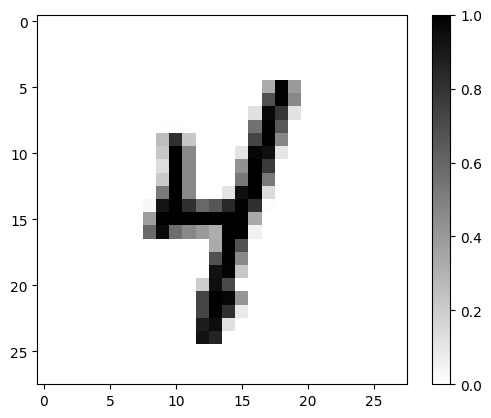

In [ ]:
import numpy
import matplotlib.pyplot as plt
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
"""
Convierte la imagen del formato de tensor de TensorFlow a una matriz NumPy y luego la redimensiona a una forma de (28, 28).
La redimensión es necesaria para que la imagen pueda ser visualizada correctamente.
"""
imagen = imagen.numpy().reshape((28,28))
#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

### 1.3.2 Visualizacion de 25 imagenes

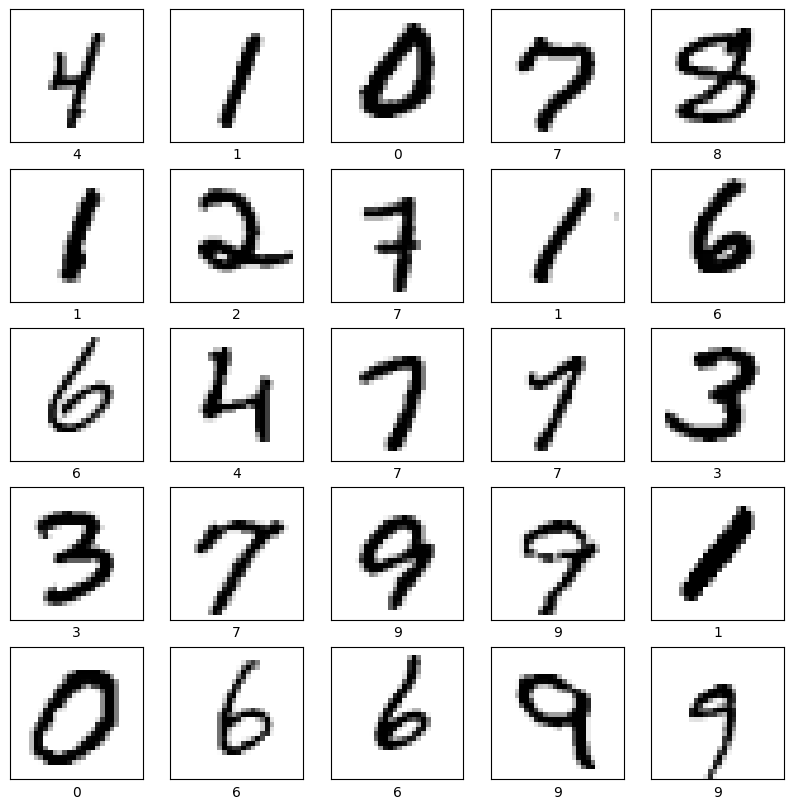

In [ ]:
#Dibujar mas
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

## 2. Creacion del modelo

### 2.1 Creacion del modelo
Este código define un modelo de red neuronal convolucional (CNN) utilizando la biblioteca TensorFlow. A continuación, se explica cada parte del código:

1. `tf.keras.Sequential`: Esto crea un modelo secuencial, que permite definir una pila de capas de manera secuencial. Las capas se apilan una encima de la otra en el orden en que se proporcionan.

2. `tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))`: Esta es una capa de convolución 2D con 32 filtros, cada uno de tamaño 3x3. La función de activación utilizada es la función ReLU (Rectified Linear Unit). La capa espera datos de entrada con forma (28, 28, 1), que es el tamaño de una imagen en escala de grises de 28x28 píxeles.

3. `tf.keras.layers.MaxPooling2D((2, 2))`: Después de la capa de convolución, se aplica una capa de agrupación máxima (max pooling) con una ventana de agrupación de 2x2. Esto reduce la dimensionalidad de la imagen y ayuda a conservar las características más importantes.

4. `tf.keras.layers.Conv2D(64, (3, 3), activation='relu')`: Otra capa de convolución 2D con 64 filtros y función de activación ReLU.

5. `tf.keras.layers.MaxPooling2D((2, 2))`: Otra capa de agrupación máxima después de la segunda capa de convolución.

6. `tf.keras.layers.Dropout(0.5)`: Esta es una capa de abandono que apaga el 50% de las neuronas durante el entrenamiento. Esto ayuda a prevenir el sobreajuste al hacer que la red sea más robusta.

7. `tf.keras.layers.Flatten()`: Esta capa aplana la salida de la capa anterior y la convierte en un vector unidimensional. Es necesario antes de conectar la red neuronal completamente conectada.

8. `tf.keras.layers.Dense(50, activation='relu')`: Una capa completamente conectada (totalmente conectada o densa) con 50 neuronas y función de activación ReLU.

9. `tf.keras.layers.Dense(50, activation='relu')`: Otra capa completamente conectada con 50 neuronas y función de activación ReLU.

10. `tf.keras.layers.Dense(10, activation='softmax')`: La capa de salida con 10 neuronas, que corresponden a las clases posibles en un problema de clasificación. La función de activación softmax se utiliza para obtener probabilidades para cada clase, lo que hace que la red sea adecuada para la clasificación multiclase.

In [ ]:
#Crear el modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),# Capa de convolucion son reuronas simples
    tf.keras.layers.MaxPooling2D((2, 2)), # Max pooling o Maxima agrupacion, tamaño de la matrix
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),# 50% Se apaguen las neuronas
    tf.keras.layers.Flatten(), #Covierte la imagen a un vector simple
    tf.keras.layers.Dense(50, activation='relu'), # Hace que la tasa de aprendizaje sea mayor
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')# Ayuda a hacer la prediccion
])


### 2.2 Compilacion del modelo
Este código compila el modelo de la red neuronal antes de comenzar el proceso de entrenamiento. Aquí está el desglose de cada línea:

1. **`modelo.compile(`:**
   - Inicia la configuración del modelo para entrenamiento.

2. **`optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),`:**
   - Especifica el optimizador que se utilizará durante el entrenamiento. En este caso, se utiliza el optimizador Adam debido a que mejora el proceso de aprendizaje.
   - `learning_rate=1e-3` establece la tasa de aprendizaje del optimizador Adam en \(0.001\).

3. **`loss=tf.keras.losses.SparseCategoricalCrossentropy(),`:**
   - Define la función de pérdida que se utilizará para evaluar el rendimiento del modelo durante el entrenamiento.
   - Se utiliza la entropía cruzada categórica dispersa (`SparseCategoricalCrossentropy`) como función de pérdida. Esta función de pérdida es comúnmente utilizada en problemas de clasificación con etiquetas categóricas, donde cada ejemplo pertenece a una única clase.

4. **`metrics=['accuracy']`:**
   - Especifica las métricas que se deben seguir durante el entrenamiento y la evaluación del modelo.
   - En este caso, la única métrica especificada es la precisión (`accuracy`). La precisión es una métrica comúnmente utilizada para problemas de clasificación y mide la proporción de predicciones correctas.

In [ ]:
#Compilar el modelo
#modelo.compile(
#    optimizer='adam',
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#    metrics=['accuracy']
#)
# Compilar el modelo con la tasa de aprendizaje inicial
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = metadatos.splits["train"].num_examples
#Accede a la información relacionada con el conjunto de entrenamiento en los metadatos del conjunto de datos MNIST.
#devuelve el numero total
num_ej_pruebas = metadatos.splits["test"].num_examples
#Algo similar a lo de arriba pero con el set de prueba

In [ ]:
#Imprimimos ambos valores para verificar si sale el numero de datos
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [ ]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 1000 #32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

### 2.3 Entrenamiento del Modelo
Esta sección del código está relacionada con el programador de tasas de aprendizaje y el entrenamiento del modelo. Aquí está el desglose línea por línea:

1. **Definir el programador de tasas de aprendizaje:**
   ```python
   alpha_programador = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))
   ```
   - Se crea un programador de tasas de aprendizaje utilizando `LearningRateScheduler`. Este programador ajustará la tasa de aprendizaje en función del número de épocas (`epoch`).
   - La tasa de aprendizaje se define como $$1 \times 10^{-3} \times 10^{\frac{\text{epoch}}{20}}$$, lo que significa que aumentará exponencialmente con cada 20 épocas.

2. **Entrenar el modelo:**
   ```python
   historial = modelo.fit(
       datos_entrenamiento,
       epochs=20,
       steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE),
       validation_data=datos_pruebas,
       callbacks=[alpha_programador]
   )
   ```
   - El modelo se entrena utilizando el método `fit` de Keras, se utiliza este comando para el aprendizaje profundo de la redes neuronales.
   - `datos_entrenamiento` es el conjunto de datos de entrenamiento.
   - `epochs=20` especifica el número total de épocas de entrenamiento.
   - `steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE)` determina el número de pasos (lotes) que se deben tomar en cada época. La función `math.ceil` se utiliza para asegurarse de que el número de pasos sea suficiente para cubrir todo el conjunto de entrenamiento.
   - `validation_data=datos_pruebas` especifica el conjunto de datos de prueba utilizado para la validación durante el entrenamiento.
   - `callbacks=[alpha_programador]` pasa el programador de tasas de aprendizaje como un callback durante el entrenamiento, es decir cuanto va ir recoriendo enbase a los epoch y a la perdida.


In [ ]:
import math

#Entrenar
#historial = modelo.fit(datos_entrenamiento,
#                       epochs=5,
#                       steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

# Definir el programador de tasas de aprendizaje
alpha_programador = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Entrenar el modelo
historial = modelo.fit(
    datos_entrenamiento,
    epochs=20,
    steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE),
    validation_data=datos_pruebas,
    callbacks=[alpha_programador]
)


Epoch 1/20
60/60 [==============================] - 97s 1s/step - loss: 0.9244 - accuracy: 0.7031 - val_loss: 0.2235 - val_accuracy: 0.9369 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 50s 829ms/step - loss: 0.2038 - accuracy: 0.9388 - val_loss: 0.1051 - val_accuracy: 0.9693 - lr: 0.0011
Epoch 3/20
60/60 [==============================] - 51s 850ms/step - loss: 0.1309 - accuracy: 0.9603 - val_loss: 0.0762 - val_accuracy: 0.9757 - lr: 0.0013
Epoch 4/20
60/60 [==============================] - 53s 882ms/step - loss: 0.0974 - accuracy: 0.9690 - val_loss: 0.0595 - val_accuracy: 0.9812 - lr: 0.0014
Epoch 5/20
60/60 [==============================] - 51s 850ms/step - loss: 0.0838 - accuracy: 0.9747 - val_loss: 0.0482 - val_accuracy: 0.9841 - lr: 0.0016
Epoch 6/20
60/60 [==============================] - 52s 871ms/step - loss: 0.0710 - accuracy: 0.9778 - val_loss: 0.0491 - val_accuracy: 0.9844 - lr: 0.0018
Epoch 7/20
60/60 [==============================] - 49s 825ms/step 

### 2.4 Muestra de la perdida

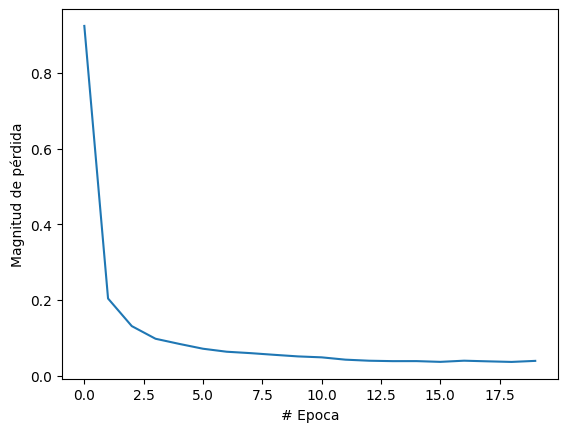

In [ ]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

En base a la grafica de perdida se puede observar que a medida que va avanzando el entrenamiento, la magnitud de la perdida se va disminuyendo lo cual es ideal ya que muestra que va reconocer todas las imagenes con sus respectivas clases, lo ideal es que llegase a 0 pero tener un numero cercano es suficiente.

### 2.5 Muestra de la comparacion de la etiquetas reales con las imagenes de prediccion
Esta sección del código tiene como objetivo visualizar una conjunto de imágenes de prueba junto con sus predicciones y etiquetas reales. En esta seccion del codigo se genera lo siguiente:

1. **Obtención de predicciones:**
   ```python
   for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
       imagenes_prueba = imagenes_prueba.numpy()
       etiquetas_prueba = etiquetas_prueba.numpy()
       predicciones = modelo.predict(imagenes_prueba)
   ```
   - Se toma un lote (en este caso, el primero) de datos de prueba.
   - Las imágenes y etiquetas se convierten a matrices NumPy para su manipulación.
   - Se obtienen predicciones del modelo utilizando el método `predict`.

2. **Funciones para graficar imágenes y barras de predicciones:**
   ```python
   def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
       # ...
   ```
   - `graficar_imagen` toma como entrada un índice `i`, un array de predicciones `arr_predicciones`, las etiquetas reales `etiquetas_reales` y las imágenes correspondientes.
   - Dibuja la imagen en una subfigura con etiquetas que indican la etiqueta predicha y su probabilidad, coloreando la etiqueta en azul si la predicción es correcta y en rojo si es incorrecta.

   ```python
   def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
       # ...
   ```
   - `graficar_valor_arreglo` toma como entrada un índice `i`, un array de predicciones `arr_predicciones` y la etiqueta real `etiqueta_real`.
   - Dibuja un gráfico de barras para las predicciones, coloreando en rojo la barra correspondiente a la predicción y en azul la barra correspondiente a la etiqueta real.

3. **Generación de la cuadrícula de imágenes:**
   ```python
   filas = 5
   columnas = 5
   num_imagenes = filas * columnas
   plt.figure(figsize=(2*2*columnas, 2*filas))
   for i in range(num_imagenes):
       plt.subplot(filas, 2*columnas, 2*i+1)
       graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
       plt.subplot(filas, 2*columnas, 2*i+2)
       graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
   ```
   - Se establece el diseño de la cuadrícula con `filas` y `columnas`.
   - Se crea una figura de Matplotlib con el tamaño especificado.
   - Para cada índice en el rango de `num_imagenes`, se crea una subfigura con dos columnas: una para la imagen y la predicción, y otra para el gráfico de barras.
   - Las funciones `graficar_imagen` y `graficar_valor_arreglo` se utilizan para llenar cada subfigura con la información correspondiente.

32/32 [==============================] - 0s 8ms/step


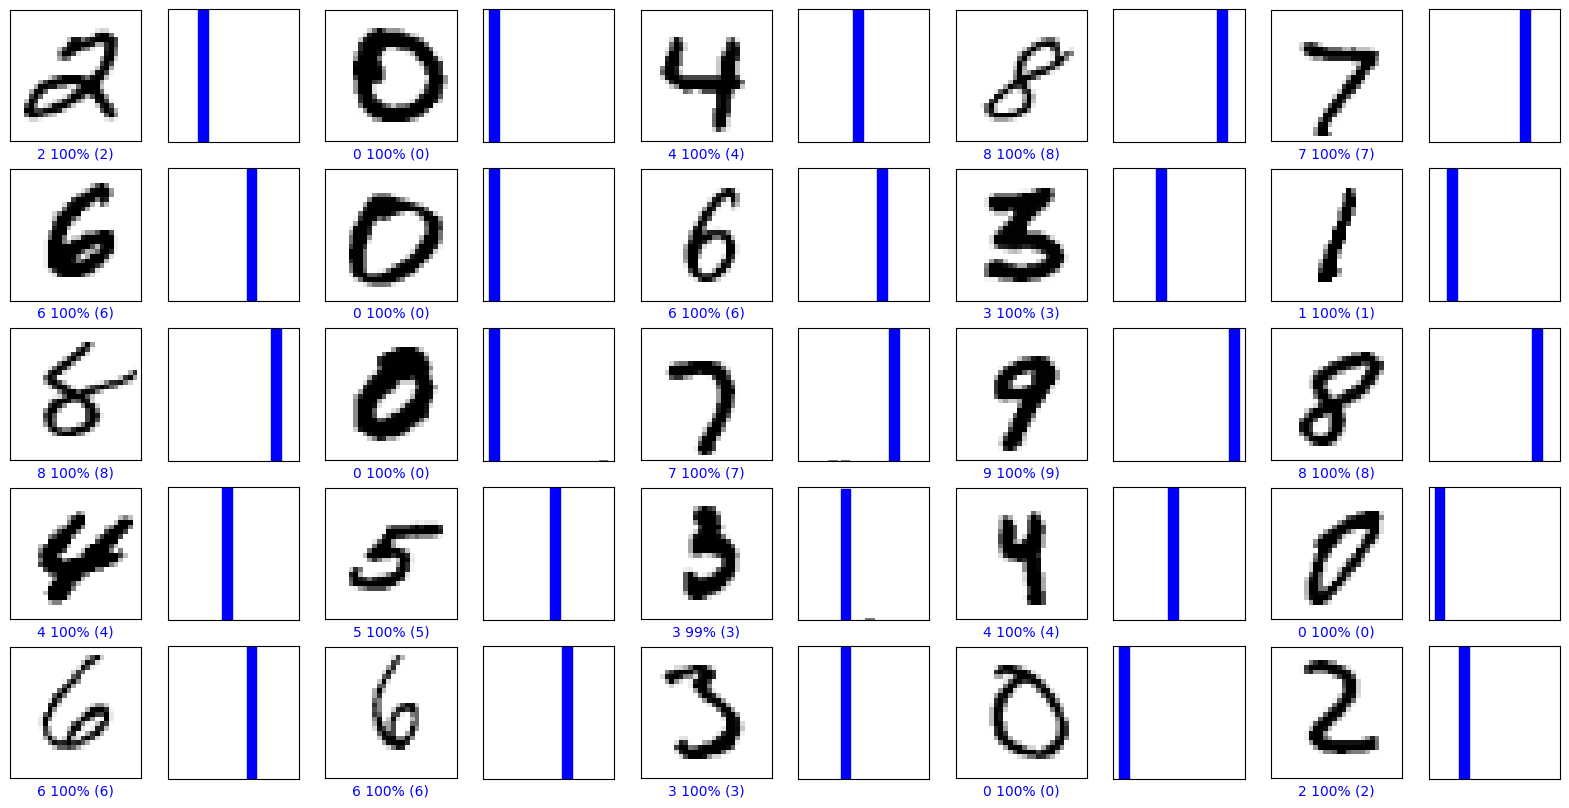

In [ ]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

## 3. Arquitectura de la red neuronal

El diagrama de bloques que se muestra representa la arquitectura de una red neuronal convolucional (CNN) utilizada para el reconocimiento de imágenes. La CNN se compone de seis capas, cada una de las cuales realiza una función diferente.

La primera capa, llamada **InputLayer**, recibe la imagen de entrada. La imagen de entrada debe tener un tamaño de 28 x 28 píxeles y un canal de color.

La segunda capa, llamada **Conv2D**, realiza una operación de convolución sobre la imagen de entrada. La convolución es una operación matemática que combina los píxeles adyacentes de la imagen para crear un nuevo píxel. La **Conv2D** utiliza un filtro de convolución de tamaño 3 x 3 con 32 filtros. Los filtros se entrenan durante el proceso de aprendizaje de la CNN.

La tercera capa, llamada **MaxPooling2D**, realiza una operación de pooling sobre la salida de la **Conv2D**. El pooling es una operación que reduce el tamaño de la imagen sin perder demasiada información. La **MaxPooling2D** utiliza una ventana de tamaño 2 x 2.

La cuarta capa, llamada **Conv2D**, realiza otra operación de convolución sobre la salida de la **MaxPooling2D**. Esta capa utiliza un filtro de convolución de tamaño 3 x 3 con 64 filtros.

La quinta capa, llamada **MaxPooling2D**, realiza otra operación de pooling sobre la salida de la **Conv2D**.

La sexta capa, llamada **Dropout**, aplica una tasa de caída de 0,2 a la salida de la **MaxPooling2D**. La tasa de caída es una técnica que ayuda a evitar el sobreajuste.

La salida de la **Dropout** se envía a la última capa, llamada **Dense**. La **Dense** es una capa de neuronas completamente conectadas que clasifica la imagen en una de las 10 clases posibles.

En este caso, son 10 clases de numeros de 0 al 9.

El diagrama de bloques se puede dividir en dos partes principales: las capas convolucionales y las capas densas. Las capas convolucionales se utilizan para extraer las características de la imagen, mientras que las capas densas se utilizan para clasificar la imagen.

Las capas convolucionales son el corazón de una CNN. Son las responsables de aprender las características importantes de las imágenes. Las capas densas son responsables de tomar estas características y clasificarlas.

El diagrama de bloques que se muestra es un ejemplo simple de una CNN. Las CNN más complejas pueden tener más capas y filtros.

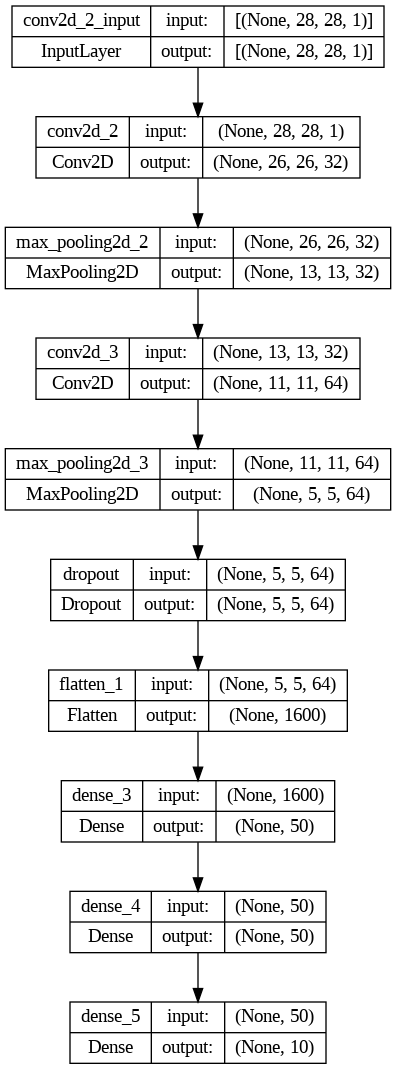

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(modelo, show_shapes=True)

In [ ]:
#Probar una imagen suelta
imagen = imagenes_prueba[8] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 34ms/step
Prediccion: 3


## 4. Curvas de presicion y perdida

 - Grafica de precision: En esta grafica se puede observar que la presicion de la red neuronal y la validadcion de precision van casi a la par llegando a ser 1, indicandonos que es muy precisio al predecir las imagenes, decir que la tener una imagen de 1 va dar una prediccion de 1.
 - Grafica de perdida: Tanto la validadcion de perdida como la perdida es aproximadamente igual a 0, indicandonos que al poner imagenes va mostrar la clase a la que pertenece si tener dificultades de predecir dicha imagen si dar resultados erroneos.

<Axes: title={'center': 'Modelo'}>

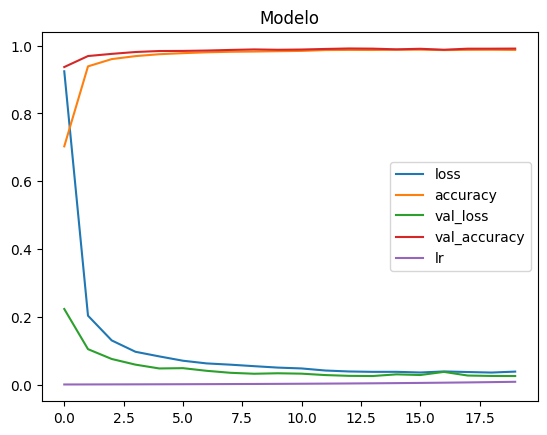

In [ ]:
import pandas as pd
pd.DataFrame(historial.history).plot(title='Modelo')

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def crear_matriz_confusion(y_verdadero, y_pred, clases=None, figsize=(15,15), text_size=15):
  mc = confusion_matrix(y_verdadero, y_pred)
  mc_normalizado = mc.astype("float")/mc.sum(axis=1)[:, np.newaxis]
  n_clases = mc.shape[0]

  fig, eje = plt.subplots(figsize=figsize)

  eje_color = eje.matshow(mc, cmap=plt.cm.Blues)
  fig.colorbar(eje_color)

  if clases:
    etiquetas = clases
  else:
    etiquetas = np.arange(n_clases)

  eje.set(
      title="Matriz de confusion",
      xlabel="Etiqueta predicción",
      ylabel="Etiqueta verdadera",
      xticks=np.arange(n_clases),
      yticks=np.arange(n_clases),
      xticklabels=etiquetas,
      yticklabels=etiquetas
  )

  eje.xaxis.set_label_position("bottom")
  eje.xaxis.tick_bottom()

  umbral = (mc.min() + mc.max()) / 2

  for i, j in itertools.product(range(mc.shape[0]), range(mc.shape[1])):
    plt.text(j, i, f"{mc[i, j]} {mc_normalizado[i, j]*100:.1f}%",
             horizontalalignment="center",
             color="white" if mc[i, j] > umbral else "black",
             size=text_size
             )

In [ ]:
y_probabilidades = modelo.predict(datos_pruebas)

10/10 [==============================] - 4s 347ms/step


In [ ]:
y_probabilidades[:5]

array([[3.2073476e-11, 6.5367471e-09, 9.9998945e-01, 1.0335321e-05,
        1.0076005e-10, 1.4633822e-10, 2.3446947e-10, 1.2588242e-07,
        4.9910469e-08, 5.7977019e-09],
       [9.9997729e-01, 2.4319309e-11, 2.7633973e-07, 1.4235654e-08,
        2.7692105e-08, 6.5580224e-07, 1.7396587e-06, 5.7191657e-10,
        2.8161237e-06, 1.7067245e-05],
       [2.2570104e-11, 5.1028409e-10, 2.4657026e-12, 6.0859184e-13,
        9.9999982e-01, 5.3541815e-10, 1.7577423e-10, 6.4250794e-10,
        3.2487730e-12, 1.3274406e-07],
       [1.2942380e-08, 1.6628125e-10, 5.4524986e-07, 4.6592703e-07,
        1.4401927e-09, 8.4339280e-07, 6.9026424e-07, 1.9840025e-09,
        9.9999732e-01, 6.8101620e-08],
       [1.7508633e-08, 5.2995833e-06, 7.4023856e-06, 2.8277331e-04,
        8.4770811e-08, 7.8097469e-07, 6.8030270e-10, 9.9958533e-01,
        1.3609457e-06, 1.1691485e-04]], dtype=float32)

In [ ]:
y_predicciones = y_probabilidades.argmax(axis=1) #Contendra los indices de las clases con las probabiliades mas altas

In [ ]:
y_probabilidades

array([[3.2073476e-11, 6.5367471e-09, 9.9998945e-01, ..., 1.2588242e-07,
        4.9910469e-08, 5.7977019e-09],
       [9.9997729e-01, 2.4319309e-11, 2.7633973e-07, ..., 5.7191657e-10,
        2.8161237e-06, 1.7067245e-05],
       [2.2570104e-11, 5.1028409e-10, 2.4657026e-12, ..., 6.4250794e-10,
        3.2487730e-12, 1.3274406e-07],
       ...,
       [1.9277773e-09, 1.5364288e-11, 3.2180869e-06, ..., 1.5605654e-10,
        9.9999255e-01, 1.2757991e-07],
       [9.9996001e-01, 3.9088341e-08, 5.9938916e-06, ..., 1.6689680e-07,
        5.5244146e-07, 3.1118492e-05],
       [1.2232471e-08, 2.7193674e-13, 1.3651319e-10, ..., 3.9447582e-13,
        2.9036430e-06, 3.4224890e-06]], dtype=float32)

In [ ]:
y_predicciones

array([2, 0, 4, ..., 8, 0, 5])

In [ ]:
y_probabilidades[0].argmax(), nombres_clases[y_probabilidades[0].argmax()] #Los nombres de las clases correspondientes a los indices predichos

(2, '2')

## 5. Curva de tasa aprendizaje Vs. Perdida

En este caso la tasa de aprendizaje nos indica la magnitud de los ajustes que se realizan en los pesos del modelo durante cada actualización de los gradientes durante el proceso de optimización, en este caso la tasa de aprendizaje va ir aumentando 0.001 cuando va pasando cada epoca. Podemos observar que a medida va disminuyendo la perdida va ir aumentando la tasa de aprendizaje.

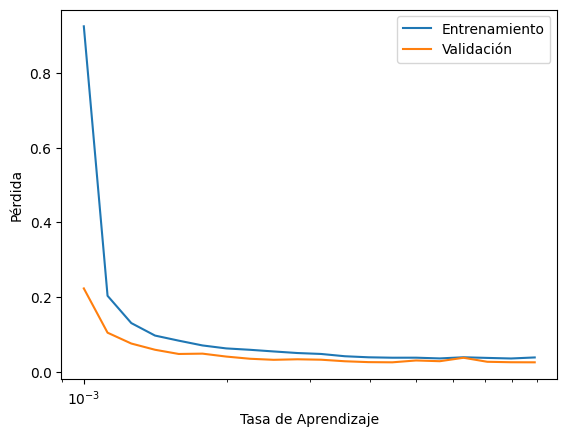

In [ ]:
# Mostrar la curva de tasa de aprendizaje vs pérdida
tasas_aprendizaje = 1e-3 * (10 ** (np.arange(20) / 20))
plt.semilogx(tasas_aprendizaje, historial.history["loss"], label='Entrenamiento')
plt.semilogx(tasas_aprendizaje, historial.history["val_loss"], label='Validación')
plt.xlabel('Tasa de Aprendizaje')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

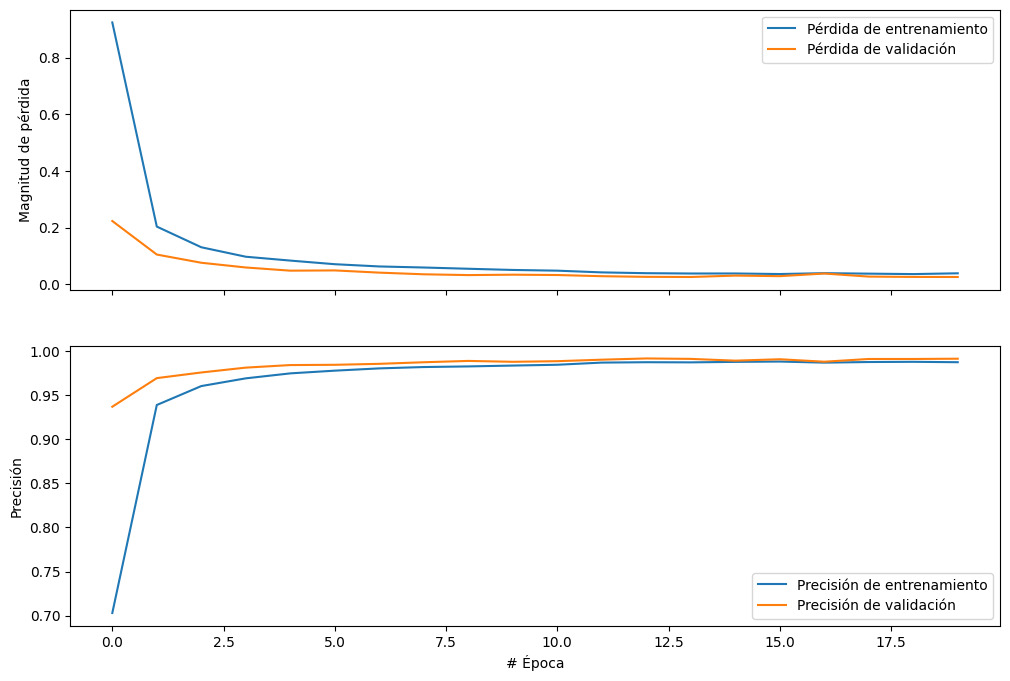

In [ ]:
# Entrenar
#historial = modelo.fit(datos_entrenamiento,
#                       epochs=40,
#                       steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE),
#                       validation_data=datos_pruebas)

# Ver la función de pérdida y precisión
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(historial.history['loss'], label='Pérdida de entrenamiento')
ax1.plot(historial.history['val_loss'], label='Pérdida de validación')
ax1.set_ylabel('Magnitud de pérdida')
ax1.legend()

ax2.plot(historial.history['accuracy'], label='Precisión de entrenamiento')
ax2.plot(historial.history['val_accuracy'], label='Precisión de validación')
ax2.set_xlabel('# Época')
ax2.set_ylabel('Precisión')
ax2.legend()

plt.show()

En la grafica de arriba se puede observar la validacion tanto de la perdida como la precision del set de entrenamiento.
- **Perdida**: En el caso de la perdida se puede observar de que al pasar las epocas va ir disminuyendo a casi llegar a 0, tanto en los datos originales como en la validacion van reduciendose.
- **Precision**: En el caso de la precision se puede observar de que al pasar las epocas va ir aumentando a casi llegar a 1, indicandonos que la presicion va ir aumentando al poner mas epocas.

# 6. Matriz de confusión

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def crear_matriz_confusion(y_verdadero, y_pred, clases=None, figsize=(15, 15), text_size=10):
    mc = confusion_matrix(y_verdadero, y_pred)
    mc_normalizado = mc.astype("float") / mc.sum(axis=1)[:, np.newaxis]
    n_clases = mc.shape[0]

    fig, eje = plt.subplots(figsize=figsize)

    eje_color = eje.matshow(mc, cmap=plt.cm.Blues)
    fig.colorbar(eje_color)

    if clases:
        etiquetas = clases
    else:
        etiquetas = np.arange(n_clases)

    eje.set(
        title="Matriz de confusion",
        xlabel="Etiqueta predicción",
        ylabel="Etiqueta verdadera",
        xticks=np.arange(n_clases),
        yticks=np.arange(n_clases),
        xticklabels=etiquetas,
        yticklabels=etiquetas
    )

    eje.xaxis.set_label_position("bottom")
    eje.xaxis.tick_bottom()

    umbral = (mc.min() + mc.max()) / 2

    for i, j in itertools.product(range(mc.shape[0]), range(mc.shape[1])):
        plt.text(j, i, f"{mc[i, j]} {mc_normalizado[i, j] * 100:.1f}%",
                 horizontalalignment="center",
                 color="white" if mc[i, j] > umbral else "black",
                 size=text_size
                 )

    plt.show()


La matriz se compone de dos dimensiones: la etiqueta verdadera y la etiqueta predicha. Las etiquetas verdaderas son las etiquetas reales de los datos de entrenamiento, mientras que las etiquetas predichas son las etiquetas que el modelo predice.

Cada celda de la matriz representa el número de datos que tienen una etiqueta verdadera y una etiqueta predicha específicas. Por ejemplo, la celda en la esquina superior izquierda de la matriz representa el número de datos que tienen una etiqueta verdadera de 0 y una etiqueta predicha de 0.

En esta matriz, los números en negrita son las celdas de la diagonal principal. Estas celdas representan el número de datos que se clasificaron correctamente. Por ejemplo, la celda en la esquina superior izquierda de la matriz indica que 974 de los datos con una etiqueta verdadera de 0 se clasificaron correctamente como 0.

Los números fuera de la diagonal principal representan los errores de clasificación. Por ejemplo, la celda en la esquina inferior izquierda de la matriz indica que 10 de los datos con una etiqueta verdadera de 0 se clasificaron incorrectamente como 9.

En general, cuanto más altos sean los números en la diagonal principal y cuanto más bajos sean los números fuera de la diagonal principal, mejor será el rendimiento del modelo.

La barra está dividida en dos partes: la parte superior de la barra representa los datos clasificados correctamente y la parte inferior de la barra representa los datos clasificados incorrectamente.

En esta matriz, la barra de la derecha indica que el modelo clasificó correctamente el 99% de los datos es decir que tiene una tasa de presicion del 99%. El 1% de los datos se clasificaron incorrectamente.

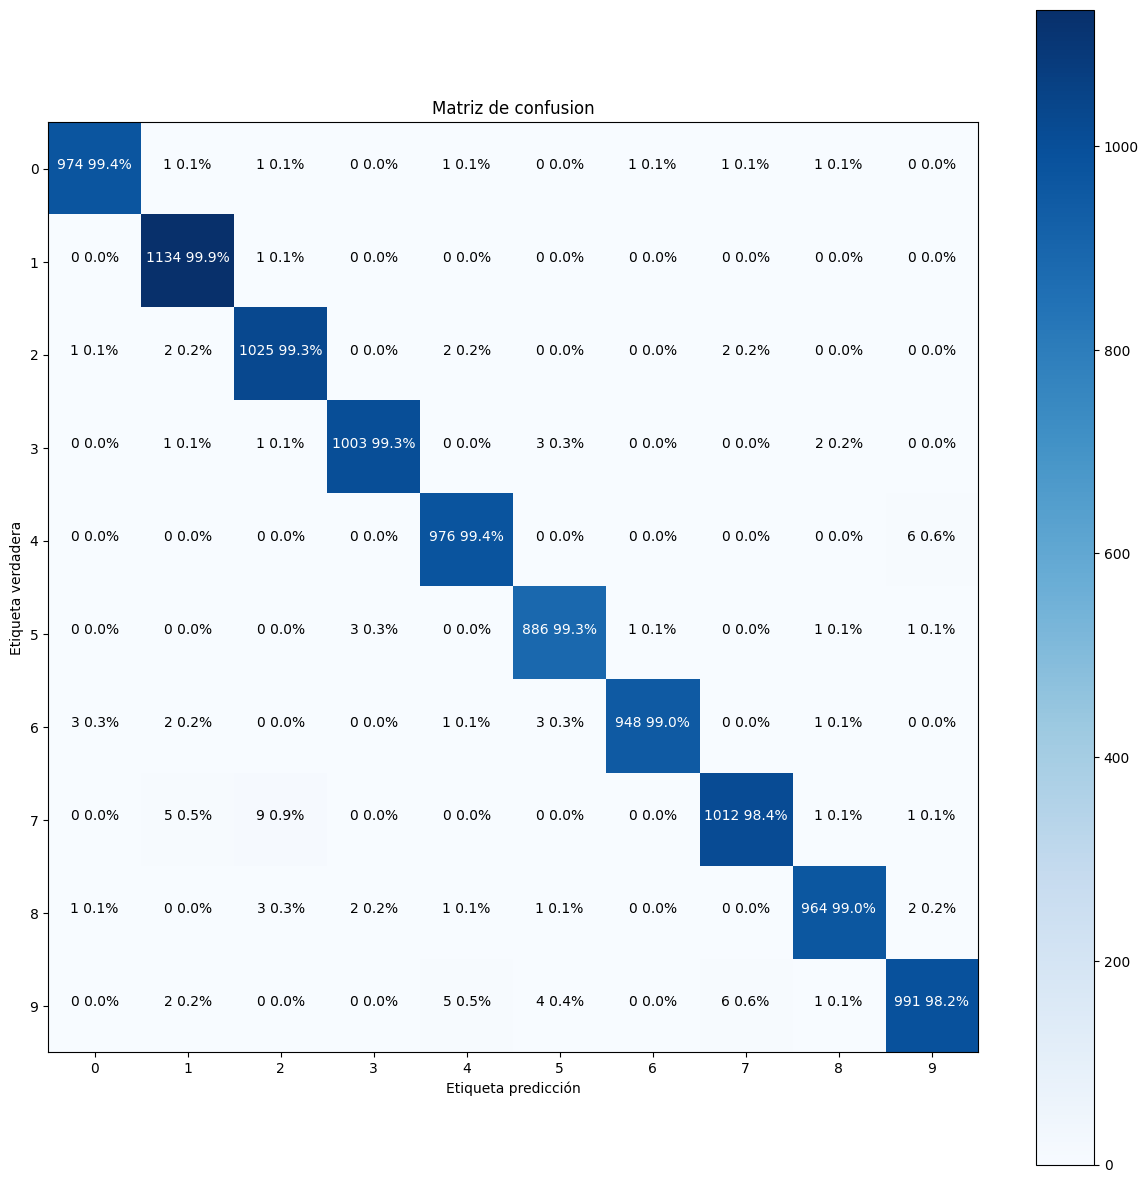

In [ ]:
# Calcular las etiquetas verdaderas
y_verdadero = np.concatenate([etiqueta.numpy() for _, etiqueta in datos_pruebas], axis=0)

# Crear y mostrar la matriz de confusión
crear_matriz_confusion(y_verdadero, y_predicciones, clases=nombres_clases)


# 7. Sumario y conclusiones

### 7.1 Sumario

In [ ]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1600)             

### 7.2 Conclusiones
**1. Arquitectura de la red:**

* La red tiene una arquitectura de red neuronal convolucional (CNN), que consta de:
    * Dos capas convolucionales (conv2d_2, conv2d_3) para la extracción de características.
    * Dos capas de agrupación máxima (max_pooling2d_2, max_pooling2d_3) para la submuestreo y la reducción de la dimensionalidad.
    * Una capa de abandono para la regularización y la prevención del sobreajuste.
    * Una capa de aplanamiento para convertir el mapa de características multidimensional en un vector único.
    * Tres capas densas (dense_3, dense_4, dense_5) para la clasificación totalmente conectada.

**2. Tamaño del modelo:**

* El modelo tiene un total de 101.926 parámetros, que es relativamente pequeño para una CNN. Esto indica que puede ser eficiente y adecuado para su implementación en dispositivos móviles o entornos con recursos limitados.

**3. Parámetros entrenables:**

* Todos los parámetros del modelo son entrenables, lo que significa que se ajustarán durante el proceso de entrenamiento para optimizar el rendimiento de la red.

**4. Buen rendimiento:**

* La red tiene una alta precisión de entrenamiento (98.78%) y una precisión de validación aún más alta (99.13%).
* La pérdida de entrenamiento y la pérdida de validación disminuyen continuamente a lo largo del entrenamiento, lo que indica que la red está aprendiendo y mejorando.

**5. Convergencia:**

* La red parece converger, lo que significa que no está mejorando significativamente en las últimas épocas. Esto es bueno porque indica que la red no está sobreajustada.

**6. Learning rate:**

* La tasa de aprendizaje se incrementa a lo largo del entrenamiento, lo que es una estrategia común para acelerar la convergencia.

**7. Posibles áreas de mejora:**

* Aunque el rendimiento es bueno, la red podría aún ser mejorada. Se pueden explorar diferentes arquitecturas, optimizadores, o técnicas de regularización para ver si se puede lograr una mayor precisión.

**8. Importancia de la validación:**

* La diferencia entre la precisión de entrenamiento y la precisión de validación es pequeña, lo que indica que la red no está sobreajustada. Esto es importante porque un modelo sobreajustado puede tener un buen rendimiento en el conjunto de entrenamiento, pero un mal rendimiento en datos no vistos.